In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import re
import os
import logging

# Helpers

In [2]:
LANDMARK_ROOT = "data"  
SAVE_ROOT_FOLDER = 'data/landmarks_kharchenko_exp_section/'
EMBEDDING_COORDS_ROOT = SAVE_ROOT_FOLDER + "embedding_coords_cache"

os.makedirs(EMBEDDING_COORDS_ROOT, exist_ok=True)

LAYER_TO_DIM = {
    0: 16,
    1: 32,
    2: 64,
    3: 64,
    4: 128, 
    5: 128,
    6: 128,
    7: 256,
    8: 256,
    9: 256,
    10: 256
}

def ensure_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)


def get_embeddings_for_layers(embeddings: np.ndarray, layers: list, layer_to_dim: dict = LAYER_TO_DIM) -> np.ndarray:
    """
    Selects and returns the embeddings for the specified layers from a concatenated embeddings array.

    Parameters:
    - embeddings (np.ndarray): The input embeddings array of shape (num_samples, total_dim).
    - layers (list): A list of layer numbers to extract embeddings for.
    - layer_to_dim (dict): A dictionary mapping layer numbers to their respective dimensions.

    Returns:
    - np.ndarray: A new embeddings array containing only the specified layers' embeddings.
    
    Raises:
    - ValueError: If any of the specified layers are not present in layer_to_dim.
    """
    # Validate input layers
    invalid_layers = [layer for layer in layers if layer not in layer_to_dim]
    if invalid_layers:
        raise ValueError(f"Layers {invalid_layers} are not present in the layer_to_dim mapping.")
    
    # Compute the starting index for each layer
    layer_start_indices = {}
    current_index = 0
    for layer in sorted(layer_to_dim.keys()):
        layer_start_indices[layer] = current_index
        current_index += layer_to_dim[layer]
    
    # Collect all column indices for the specified layers
    selected_columns = []
    for layer in layers:
        start = layer_start_indices[layer]
        dim = layer_to_dim[layer]
        selected_columns.extend(range(start, start + dim))
    
    # Select and return the columns from the embeddings array
    return embeddings[:, selected_columns]


def generate_embedding_config_folder(conf_threshold, layer_list):
    layer_str = "_".join(map(str, layer_list)) if layer_list else "all"
    folder_name = f"conf-{conf_threshold}_layers-{layer_str}"
    return folder_name


def _numeric_id(fname: str) -> int:
    """Extract an integer id from filenames like '00012.png' / 'img_34.jpg'."""
    m = re.search(r"(\d+)", fname)
    return int(m.group(1)) if m else -1

# Proxy metrics to select the best embedding config

In [3]:
# ------------------------------------------------------------------
#  calculate_top_k_accuracy_satelite2drone
# ------------------------------------------------------------------
def calculate_top_k_accuracy_satelite2drone(
    max_indicies: list[int],
    sum_indicies: list[int],
    avg_indicies: list[int],
    localisation_radius: int = 3,
    contamination: float = 0.2
) -> dict[str, int]:
    """
    Satellite → Drone retrieval evaluation with outlier split.
    Builds joint embeddings from {max, sum, avg} variants, runs
    Isolation Forest to separate outliers / inliers and computes
    top‑1 / top‑5 localisation accuracy for each group.

    Returns
    -------
    dict[str, int]  # percentage values, rounded to nearest int
    """
    logging.info("Loading embeddings …")

    SAT_PATHS = {
        "max": "data/landmarks_satellite_max_urban/embeddings.npy",
        "sum": "data/landmarks_satellite_sum_urban/embeddings.npy",
        "avg": "data/landmarks_satellite_avg_urban/embeddings.npy"
    }
    DR_PATHS = {
        "max": "data/landmarks_drone_max_urban/embeddings.npy",
        "sum": "data/landmarks_drone_sum_urban/embeddings.npy",
        "avg": "data/landmarks_drone_avg_urban/embeddings.npy"
    }

    # -------- 1. Build satellite embeddings ---------------------------------
    sat_emb_parts = [
        get_embeddings_for_layers(np.load(SAT_PATHS["max"]), max_indicies, LAYER_TO_DIM),
        get_embeddings_for_layers(np.load(SAT_PATHS["sum"]), sum_indicies, LAYER_TO_DIM),
        get_embeddings_for_layers(np.load(SAT_PATHS["avg"]), avg_indicies, LAYER_TO_DIM)
    ]
    sat_emb = np.concatenate(sat_emb_parts, axis=1)

    # -------- 2. Build drone embeddings -------------------------------------
    dr_emb_parts = [
        get_embeddings_for_layers(np.load(DR_PATHS["max"]), max_indicies, LAYER_TO_DIM),
        get_embeddings_for_layers(np.load(DR_PATHS["sum"]), sum_indicies, LAYER_TO_DIM),
        get_embeddings_for_layers(np.load(DR_PATHS["avg"]), avg_indicies, LAYER_TO_DIM)
    ]
    dr_emb = np.concatenate(dr_emb_parts, axis=1)

    # -------- 3. Confidence‑based filtering ---------------------------------
    df_sat_meta = pd.read_csv("data/landmarks_satellite_sum_urban/info.csv")
    df_dr_meta = pd.read_csv("data/landmarks_drone_sum_urban/info.csv")
    sat_mask = df_sat_meta["conf"] >= 0.5
    dr_mask  = df_dr_meta["conf"]  >= 0.5

    sat_emb = sat_emb[sat_mask.values]
    df_sat_meta = df_sat_meta[sat_mask]
    sat_img_ids = df_sat_meta["image"].apply(_numeric_id).to_numpy()

    dr_emb  = dr_emb[dr_mask.values]
    df_dr_meta = df_dr_meta[dr_mask]
    dr_img_ids = df_dr_meta["image"].apply(_numeric_id).to_numpy()

    # -------- 4. PCA caching (same style as UI) ------------------------------
    conf_thr = 0.5
    all_layers = sorted(set(max_indicies + sum_indicies + avg_indicies))
    emb_cfg_folder = os.path.join(
        EMBEDDING_COORDS_ROOT,
        generate_embedding_config_folder(conf_thr, all_layers)
    )
    ensure_folder(emb_cfg_folder)
    pca_path = os.path.join(emb_cfg_folder, "pca_coords.npy")
    if os.path.exists(pca_path):
        pass
    else:
        pca = PCA(n_components=2, random_state=42)
        pca_coords = pca.fit_transform(sat_emb)
        np.save(pca_path, pca_coords)

    # -------- 5. Outlier detection ------------------------------------------
    iso = IsolationForest(n_estimators=500, contamination=contamination, random_state=42, n_jobs=6)
    iso_lbl = iso.fit_predict(sat_emb)          # 1=inlier, -1=outlier
    inlier_mask = (iso_lbl == 1)
    outlier_mask = (iso_lbl == -1)

    # -------- 6. Fit NN on drone embeddings ---------------------------------
    nn_dr = NearestNeighbors(n_neighbors=5, metric='euclidean', n_jobs=6)
    nn_dr.fit(dr_emb)

    def _eval_group(query_emb_mask: np.ndarray) -> tuple[int, int]:
        """Returns (top1%, top5%) for given query set."""
        query_emb_idx = np.where(query_emb_mask)[0]

        query_emb = sat_emb[query_emb_idx]

        if len(query_emb) == 0:
            return 0, 0
        
        dists, dr_matched_idx = nn_dr.kneighbors(query_emb, n_neighbors=5, return_distance=True)
        # dr_matched_idx shape: (Q, 5) – indices into dr_emb

        matched_dr_img_ids = dr_img_ids[dr_matched_idx]
        query_sat_img_ids = sat_img_ids[query_emb_idx]

        diff = np.abs(matched_dr_img_ids - query_sat_img_ids[:, None])

        correct1 = np.sum(diff[:, 0] <= localisation_radius)
        correct5 = np.sum(np.any(diff <= localisation_radius, axis=1))
        top1_pct = correct1 / len(query_emb_idx)
        top5_pct = correct5 / len(query_emb_idx)
        return top1_pct, top5_pct

    # Evaluate inliers
    in_top1, in_top5 = _eval_group(inlier_mask)  # index offset = 0
    # Evaluate outliers
    out_top1, out_top5 = _eval_group(outlier_mask)

    return {
        "inliers_top1":  in_top1,
        "inliers_top5":  in_top5,
        "outliers_top1": out_top1,
        "outliers_top5": out_top5
    }


# ------------------------------------------------------------------
#  calculate_top_k_accuracy_satelite2satelite
# ------------------------------------------------------------------
def calculate_top_k_accuracy_satelite2satelite(
    max_indicies: list[int],
    sum_indicies: list[int],
    avg_indicies: list[int],
    localisation_radius: int = 3,
    contamination: float = 0.2
) -> dict[str, int]:
    """
    Satellite → Satellite retrieval evaluation with outlier split.
    Self‑match is skipped; we look at neighbours #2 – #6.

    Returns
    -------
    dict[str, int]  # percentage values, rounded to nearest int
    """
    logging.info("Loading embeddings …")

    SAT_PATHS = {
        "max": "data/landmarks_satellite_max_urban/embeddings.npy",
        "sum": "data/landmarks_satellite_sum_urban/embeddings.npy",
        "avg": "data/landmarks_satellite_avg_urban/embeddings.npy"
    }

    sat_emb_parts = [
        get_embeddings_for_layers(np.load(SAT_PATHS["max"]), max_indicies, LAYER_TO_DIM),
        get_embeddings_for_layers(np.load(SAT_PATHS["sum"]), sum_indicies, LAYER_TO_DIM),
        get_embeddings_for_layers(np.load(SAT_PATHS["avg"]), avg_indicies, LAYER_TO_DIM)
    ]
    sat_emb = np.concatenate(sat_emb_parts, axis=1)

    df_sat_meta = pd.read_csv("data/landmarks_satellite_sum_urban/info.csv")
    sat_mask = df_sat_meta["conf"] > 0.5

    sat_emb = sat_emb[sat_mask.values]
    df_sat_meta = df_sat_meta[sat_mask]
    sat_img_ids = df_sat_meta["image"].apply(_numeric_id).to_numpy()

    # PCA caching as before
    conf_thr = 0.5
    all_layers = sorted(set(max_indicies + sum_indicies + avg_indicies))
    emb_cfg_folder = os.path.join(
        EMBEDDING_COORDS_ROOT,
        generate_embedding_config_folder(conf_thr, all_layers)
    )
    ensure_folder(emb_cfg_folder)
    pca_path = os.path.join(emb_cfg_folder, "pca_coords.npy")
    if not os.path.exists(pca_path):
        pca = PCA(n_components=2, random_state=42)
        np.save(pca_path, pca.fit_transform(sat_emb))

    # Outlier detection
    iso = IsolationForest(n_estimators=500, contamination=contamination, random_state=42, n_jobs=6)
    iso_lbl = iso.fit_predict(sat_emb)
    inlier_mask = (iso_lbl == 1)
    outlier_mask = (iso_lbl == -1)

    # NN on satellite embeddings themselves
    nn_sat = NearestNeighbors(n_neighbors=6, metric='euclidean', n_jobs=6)
    nn_sat.fit(sat_emb)

    def _eval_group(mask: np.ndarray) -> tuple[int, int]:
        query_emb_idx = np.where(mask)[0]

        if query_emb_idx.size == 0:
            return 0, 0
        
        query_emb = sat_emb[query_emb_idx]
        
        dists, matched_emb_idx = nn_sat.kneighbors(query_emb, n_neighbors=6, return_distance=True)
        
        # drop self‑index (always first)
        matched_emb_idx = matched_emb_idx[:, 1:6]
        matched_sat_img_ids = sat_img_ids[matched_emb_idx]
        query_sat_img_ids = sat_img_ids[query_emb_idx]

        diff = np.abs(matched_sat_img_ids - query_sat_img_ids[:, None])
        correct1 = np.sum(diff[:, 0] <= localisation_radius)
        correct5 = np.sum(np.any(diff <= localisation_radius, axis=1))
        top1_pct = correct1 / query_emb_idx.size
        top5_pct = correct5 / query_emb_idx.size
        return top1_pct, top5_pct

    in_top1, in_top5 = _eval_group(inlier_mask)
    out_top1, out_top5 = _eval_group(outlier_mask)

    return {
        "inliers_top1":  in_top1,
        "inliers_top5":  in_top5,
        "outliers_top1": out_top1,
        "outliers_top5": out_top5
    }

In [31]:
calculate_top_k_accuracy_satelite2satelite(
    max_indicies= [10],
    sum_indicies= [],
    avg_indicies= [],
    localisation_radius = 3,
    contamination=0.1
)

{'inliers_top1': np.float64(0.6618209640397857),
 'inliers_top5': np.float64(0.7731191022698292),
 'outliers_top1': np.float64(0.9263565891472868),
 'outliers_top5': np.float64(0.9777131782945736)}

In [53]:
calculate_top_k_accuracy_satelite2satelite(
    max_indicies= [],
    sum_indicies= [],
    avg_indicies= [10],
    localisation_radius = 3,
    contamination=0.1
)

{'inliers_top1': np.float64(0.6917030097453293),
 'inliers_top5': np.float64(0.7872718462283961),
 'outliers_top1': np.float64(0.8439922480620154),
 'outliers_top5': np.float64(0.9452519379844961)}

In [56]:
calculate_top_k_accuracy_satelite2drone(
    max_indicies= [],
    sum_indicies= [],
    avg_indicies= [10],
    localisation_radius = 3,
    contamination=0.1
)

{'inliers_top1': np.float64(0.03257416680127066),
 'inliers_top5': np.float64(0.09368438055241479),
 'outliers_top1': np.float64(0.09689922480620156),
 'outliers_top5': np.float64(0.20881782945736435)}

In [ ]:
calculate_top_k_accuracy_satelite2drone(
    max_indicies= [],
    sum_indicies= [],
    avg_indicies= [10],
    localisation_radius = 3,
    contamination=0.1
)

{'inliers_top1': np.float64(0.04818823022667313),
 'inliers_top5': np.float64(0.11565175254401551),
 'outliers_top1': np.float64(0.1690891472868217),
 'outliers_top5': np.float64(0.29748062015503873)}

# Run Greedy Search Algo

In [87]:
import itertools
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------------------------------------------------------
# decision target = outlier‑top‑5
# ------------------------------------------------------------------
def _outlier_score(metric_dict: Dict[str, float]) -> float:
    return metric_dict["outliers_top1"]


# ------------------------------------------------------------------
# greedy forward‑selection (sequential – no multiprocessing)
# ------------------------------------------------------------------
def _greedy_layer_selection(
    aggregation: str,
    metric_fns: List[Callable],
    layer_pool: Tuple[int, ...] = tuple(range(11)),
    localisation_radius: int = 3,
    contamination: float = 0.2
) -> Tuple[List[int], Dict[str, float], pd.DataFrame]:
    """
    Select layers for ONE aggregation (‘max’ / ‘sum’ / ‘avg’) by maximising
    outlier‑top‑5 accuracy.  Evaluates candidates sequentially.
    """
    selected: List[int] = []
    remaining = list(layer_pool)
    step = 0
    rows: List[Dict] = []
    best_score = -np.inf
    best_metric_dict: Dict[str, float] | None = None

    agg2lists = {
        "max": (selected, [], []),
        "sum": ([], selected, []),
        "avg": ([], [], selected),
    }

    while remaining:
        step += 1
        
        max_l, sum_l, avg_l = agg2lists[aggregation]
        step_best: tuple | None = None  # (layer, metric_name, score, res)

        # --------------------------------------------------------------
        # evaluate every (remaining layer × metric function) combination
        # --------------------------------------------------------------
        for cand_layer, fn in itertools.product(remaining, metric_fns):
            # prepare copies so original lists stay unchanged
            max_c, sum_c, avg_c = max_l.copy(), sum_l.copy(), avg_l.copy()
            if aggregation == "max":
                max_c.append(cand_layer)
            elif aggregation == "sum":
                sum_c.append(cand_layer)
            else:
                avg_c.append(cand_layer)

            res = fn(
                max_indicies=max_c,
                sum_indicies=sum_c,
                avg_indicies=avg_c,
                localisation_radius=localisation_radius,
                contamination=contamination
            )
            score = _outlier_score(res)
            increment = score - best_score if best_score > -np.inf else score

            print(f'Completed:  max={max_c} | sum={sum_c} | avg={avg_c} | agg={aggregation} | fn={fn.__name__} | score={score} | increment={increment} | best_score={best_score}')

            rows.append(
                {
                    "step": step,
                    "layer_tested": cand_layer,
                    "metric_name": fn.__name__,
                    "inliers_top1": res["inliers_top1"],
                    "inliers_top5": res["inliers_top5"],
                    "outliers_top1": res["outliers_top1"],
                    "outliers_top5": res["outliers_top5"],
                    "outlier_score": score,
                    "increment": increment,
                    "aggregation": aggregation,
                    "accepted": False,
                }
            )

            if (step_best is None) or (score > step_best[2]):
                step_best = (cand_layer, fn.__name__, score, res, increment)

        # decide whether to accept the best candidate for this step
        cand_layer, metric_name, cand_score, cand_res, cand_inc = step_best
        if cand_score > best_score:
            selected.append(cand_layer)
            best_score = cand_score
            best_metric_dict = cand_res
            remaining.remove(cand_layer)

            # flag the accepted record
            for r in rows[::-1]:          # iterate backwards for speed
                if (
                    r["step"] == step
                    and r["layer_tested"] == cand_layer
                    and r["metric_name"] == metric_name
                ):
                    r["accepted"] = True
                    break
        else:
            break  # no further positive improvement ⇒ stop

    df_steps = pd.DataFrame(rows)
    return selected, best_metric_dict, df_steps


# ------------------------------------------------------------------
# run selection for all aggregations & plot accepted increments only
# ------------------------------------------------------------------
def run_layer_selection(
    metric_fns: List[Callable],
    layer_pool: Tuple[int, ...] = tuple(range(11)),
    localisation_radius: int = 3,
    contamination: float = 0.2
) -> Tuple[Dict[str, List[int]], Dict[str, Dict[str, float]], pd.DataFrame]:
    """
    Executes greedy layer selection for each aggregation (‘max’, ‘sum’, ‘avg’).
    Returns selected layers, final metric dicts, and a DataFrame of all steps.
    Produces a Plotly figure showing **only** the positive increments
    of accepted layers (one marker per step).
    """
    final_layers: Dict[str, List[int]] = {}
    final_metrics: Dict[str, Dict[str, float]] = {}
    dfs: List[pd.DataFrame] = []

    for agg in [
        "max", 
        "sum", 
        "avg"
    ]:
        sel, met, df_steps = _greedy_layer_selection(
            aggregation=agg,
            metric_fns=metric_fns,
            layer_pool=layer_pool,
            localisation_radius=localisation_radius,
            contamination=contamination
        )
        final_layers[agg] = sel
        final_metrics[agg] = met
        dfs.append(df_steps)

    df_all = pd.concat(dfs, ignore_index=True)

    # ----------------------------- visualisation -----------------------------
    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["max", "sum", "avg"],
        shared_yaxes=True,
    )

    for col, agg in enumerate(["max", "sum", "avg"], start=1):
        sub_df = df_all[(df_all["aggregation"] == agg) & (df_all["accepted"])]
        if sub_df.empty:
            continue

        for metric_name, grp in sub_df.groupby("metric_name"):
            fig.add_trace(
                go.Scatter(
                    x=grp["step"],
                    y=grp["outlier_score"],
                    mode="lines+markers",
                    name=metric_name,
                    showlegend=(col == 1),  # legend only once
                ),
                row=1,
                col=col,
            )

        fig.update_xaxes(title_text="Step", row=1, col=col)

    fig.update_yaxes(title_text="Increment", row=1, col=1)
    fig.update_layout(
        title_text="Incremental Improvement per Step (accepted layers only)"
    )
    fig.show()

    return final_layers, final_metrics, df_all

In [88]:
# List of performance metric functions to consider
metric_functions = [
    calculate_top_k_accuracy_satelite2drone,
]

selected_layers, final_perf, df_trace = run_layer_selection(metric_functions, contamination=0.2)

df_trace.to_csv('data/df_trace_satelite2drone.csv', index=False)

print("Selected layers:", selected_layers)
print("Final performance:", final_perf)

Completed:  max=[0] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2drone | score=0.009205426356589148 | increment=0.009205426356589148 | best_score=-inf
Completed:  max=[1] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2drone | score=0.015019379844961241 | increment=0.015019379844961241 | best_score=-inf
Completed:  max=[2] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2drone | score=0.018168604651162792 | increment=0.018168604651162792 | best_score=-inf
Completed:  max=[3] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2drone | score=0.03512596899224806 | increment=0.03512596899224806 | best_score=-inf
Completed:  max=[4] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2drone | score=0.06758720930232558 | increment=0.06758720930232558 | best_score=-inf
Completed:  max=[5] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2drone | score=0.06976744186046512 | increment=0.0697

Selected layers: {'max': [9, 6, 10], 'sum': [6, 9, 10, 8], 'avg': [9]}
Final performance: {'max': {'inliers_top1': np.float64(0.051971651826276576), 'inliers_top5': np.float64(0.1421043067417772), 'outliers_top1': np.float64(0.17562984496124032), 'outliers_top5': np.float64(0.3234011627906977)}, 'sum': {'inliers_top1': np.float64(0.04718638318492943), 'inliers_top5': np.float64(0.12302380519716519), 'outliers_top1': np.float64(0.16666666666666666), 'outliers_top5': np.float64(0.3028100775193798)}, 'avg': {'inliers_top1': np.float64(0.04240111454358229), 'inliers_top5': np.float64(0.11460415530922527), 'outliers_top1': np.float64(0.10440891472868218), 'outliers_top5': np.float64(0.22214147286821706)}}


In [4]:
calculate_top_k_accuracy_satelite2drone(
    max_indicies= [9, 10, 6],
    sum_indicies= [],
    avg_indicies= [],
    localisation_radius = 3,
    contamination=0.2
)

{'inliers_top1': np.float64(0.05142649463928766),
 'inliers_top5': np.float64(0.14028711611848083),
 'outliers_top1': np.float64(0.17781007751937986),
 'outliers_top5': np.float64(0.33066860465116277)}

In [5]:
calculate_top_k_accuracy_satelite2drone(
    max_indicies= [9, 10, 6],
    sum_indicies= [6, 9, 10, 8],
    avg_indicies= [],
    localisation_radius = 3,
    contamination=0.2
)

{'inliers_top1': np.float64(0.04809497849657762),
 'inliers_top5': np.float64(0.12932339935792597),
 'outliers_top1': np.float64(0.17102713178294573),
 'outliers_top5': np.float64(0.31031976744186046)}

In [ ]:
calculate_top_k_accuracy_satelite2drone(
    max_indicies= [9, 10, 6],
    sum_indicies= [],
    avg_indicies= [5, 9],
    localisation_radius = 3,
    contamination=0.2
)

{'inliers_top1': np.float64(0.047913259434247985),
 'inliers_top5': np.float64(0.13701617299654734),
 'outliers_top1': np.float64(0.11991279069767442),
 'outliers_top5': np.float64(0.25726744186046513)}

In [89]:
# List of performance metric functions to consider
metric_functions = [
    calculate_top_k_accuracy_satelite2satelite,
]

selected_layers, final_perf, df_trace = run_layer_selection(metric_functions, contamination=0.2)

df_trace.to_csv('data/df_trace_satelite2satelite.csv', index=False)

print("Selected layers:", selected_layers)
print("Final performance:", final_perf)

Completed:  max=[0] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2satelite | score=0.17054263565891473 | increment=0.17054263565891473 | best_score=-inf
Completed:  max=[1] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2satelite | score=0.32194767441860467 | increment=0.32194767441860467 | best_score=-inf
Completed:  max=[2] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2satelite | score=0.6303294573643411 | increment=0.6303294573643411 | best_score=-inf
Completed:  max=[3] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2satelite | score=0.5469961240310077 | increment=0.5469961240310077 | best_score=-inf
Completed:  max=[4] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2satelite | score=0.6954941860465116 | increment=0.6954941860465116 | best_score=-inf
Completed:  max=[5] | sum=[] | avg=[] | agg=max | fn=calculate_top_k_accuracy_satelite2satelite | score=0.6921027131782945 | increment=0

Selected layers: {'max': [9, 10, 4], 'sum': [10, 9], 'avg': [9, 10]}
Final performance: {'max': {'inliers_top1': np.float64(0.7431098188866678), 'inliers_top5': np.float64(0.8403295172330244), 'outliers_top1': np.float64(0.8909883720930233), 'outliers_top5': np.float64(0.9629360465116279)}, 'sum': {'inliers_top1': np.float64(0.6235992488945423), 'inliers_top5': np.float64(0.7299654733781573), 'outliers_top1': np.float64(0.8236434108527132), 'outliers_top5': np.float64(0.9256298449612403)}, 'avg': {'inliers_top1': np.float64(0.721606396510994), 'inliers_top5': np.float64(0.7824822823914228), 'outliers_top1': np.float64(0.8946220930232558), 'outliers_top5': np.float64(0.9670542635658915)}}


In [77]:
df_trace

,step,layer_tested,metric_name,inliers_top1,inliers_top5,outliers_top1,outliers_top5,outlier_score,increment,aggregation,accepted
0,1,0,calculate_top_k_accuracy_satelite2drone,0.009571,0.039372,0.009205,0.033915,0.033915,0.033915,max,False
1,1,0,calculate_top_k_accuracy_satelite2satelite,0.081228,0.206191,0.170543,0.348353,0.348353,0.348353,max,False
2,1,1,calculate_top_k_accuracy_satelite2drone,0.009752,0.043976,0.015019,0.051357,0.051357,0.051357,max,False
3,1,1,calculate_top_k_accuracy_satelite2satelite,0.169423,0.343631,0.321948,0.527616,0.527616,0.527616,max,False
4,1,2,calculate_top_k_accuracy_satelite2drone,0.012902,0.048458,0.018169,0.066618,0.066618,0.066618,max,False
5,1,2,calculate_top_k_accuracy_satelite2satelite,0.636198,0.796111,0.630329,0.765019,0.765019,0.765019,max,False
6,1,3,calculate_top_k_accuracy_satelite2drone,0.017687,0.065782,0.035126,0.106589,0.106589,0.106589,max,False
7,1,3,calculate_top_k_accuracy_satelite2satelite,0.448301,0.663153,0.546996,0.733043,0.733043,0.733043,max,False
8,1,4,calculate_top_k_accuracy_satelite2drone,0.021019,0.070931,0.067587,0.155523,0.155523,0.155523,max,False
9,1,4,calculate_top_k_accuracy_satelite2satelite,0.690351,0.826701,0.695494,0.835998,0.835998,0.835998,max,False


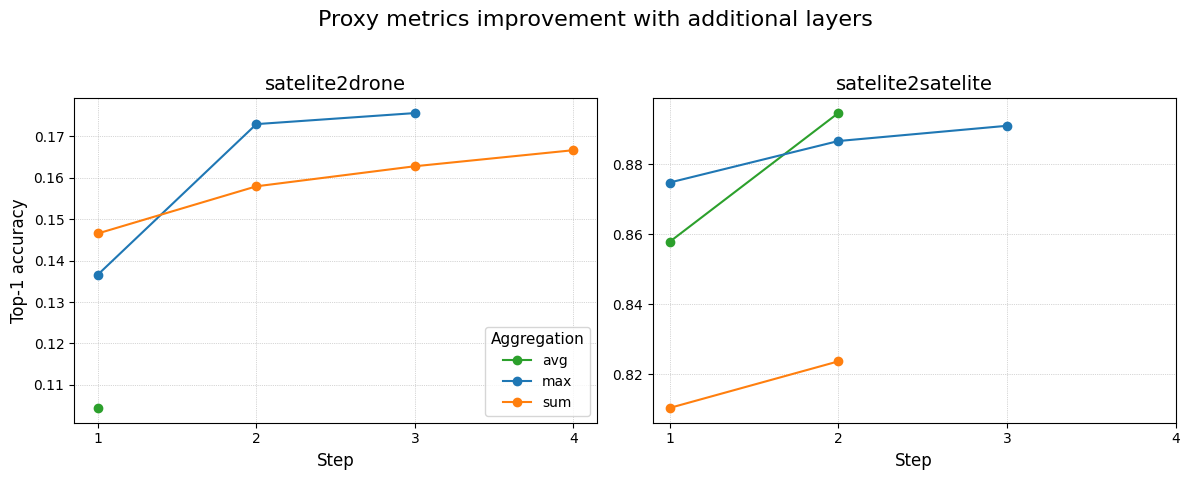

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


def plot_layer_selection_results(df,
                                 title: str = "Layer selection",
                                 ylabel: str = "Outlier top‑5 increment") -> plt.Figure:
    """Plot accepted increments per step.

    Parameters
    ----------
    csv_path : str or Path
        Path to df_trace.csv produced by the selection routine.
    title : str
        Overall plot title.
    ylabel : str
        Y‑axis label for both sub‑plots.

    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    # Filter only accepted positive increments
    mask = (df["accepted"] == True) & (df["increment"] > 0)
    df_plot = df[mask].copy()

    if df_plot.empty:
        raise ValueError("No data to plot. Check the DataFrame contents.")

    # Expect exactly two metric functions
    metrics = sorted(df_plot["metric_name"].unique())
    if len(metrics) != 2:
        raise ValueError(f"Expected exactly 2 metric functions, found {metrics}")

    # Colour mapping per aggregation
    agg_colors = {
        "max": "tab:blue",
        "sum": "tab:orange",
        "avg": "tab:green",
    }

    # Create subplots with independent scales
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Set overall title
    fig.suptitle(title, fontsize=16)

    for ax, metric in zip(axes, metrics):
        sub = df_plot[df_plot["metric_name"] == metric]
        for agg, grp in sub.groupby("aggregation"):
            grp_sorted = grp.sort_values("step")
            ax.plot(
                grp_sorted["step"],
                grp_sorted["outlier_score"],
                marker="o",
                label=agg,
                color=agg_colors.get(agg),
            )
        # Axis labels and ticks
        metric = 'satelite2drone' if metric.endswith('satelite2drone') else 'satelite2satelite'
        ax.set_title(metric, fontsize=14)
        ax.set_xlabel("Step", fontsize=12)
        ax.set_xticks(sorted(df_plot["step"].unique()))
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(True, linestyle=":", linewidth=0.5)

    # Y-axis label on first subplot only
    axes[0].set_ylabel(ylabel, fontsize=12)

    # Legend on first subplot
    legend = axes[0].legend(title="Aggregation", loc="best", fontsize=10)
    plt.setp(legend.get_title(), fontsize=11)

    # Tight layout
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig


df1 = pd.read_csv('data/df_trace_satelite2drone.csv')
df2 = pd.read_csv('data/df_trace_satelite2satelite.csv')
df = pd.concat([df1, df2], axis=0)
# Example call for quick testing
plot_layer_selection_results(
    df,
    title="Proxy metrics improvement with additional layers",
    ylabel="Top-1 accuracy"
)
plt.show()
